In [2]:
# chapter 3 with MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


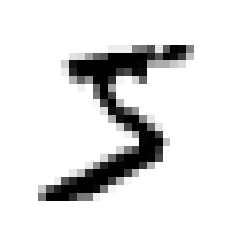

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28,28)

%matplotlib inline
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

In [15]:
y[0]

'5'

In [17]:
import numpy as np
y = y.astype(np.uint8)

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [19]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
print(y_train_5)

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool


In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
# this is a simple binary classifier for 5 or not 5

SGDClassifier(random_state=42)

In [22]:
sgd_clf.predict([some_digit])

array([ True])

In [24]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [25]:
# but base classifier also does well
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [26]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [27]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [30]:
y_train_pred.shape # each data is in cross_val only once!

(60000,)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [32]:
y_train_perfect_predictions = y_train_5 # pretending
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [36]:
# precision
# TP/(TP+FP)

# recall
# TP/(TP+FN)

In [37]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [38]:
(3530.0)/(3530+687)

0.8370879772350012

In [39]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [40]:
(3530.0)/(3530+1891)

0.6511713705958311

In [41]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [42]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [44]:
y_some_digit_pred

array([ True])

In [45]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [46]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [49]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

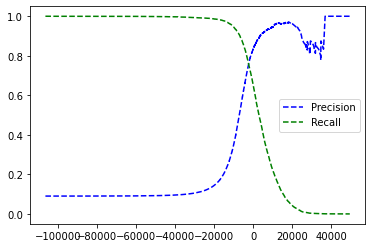

In [50]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()
    plt.show()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

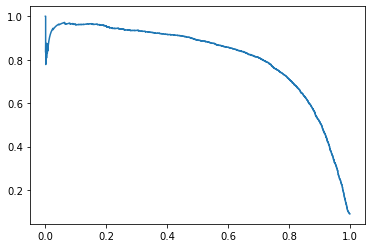

In [52]:
plt.plot(recalls[:-1], precisions[:-1])
plt.show()

In [53]:
# say you want to get >=90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [54]:
threshold_90_precision

3370.0194991439557

In [55]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [56]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [57]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

No handles with labels found to put in legend.


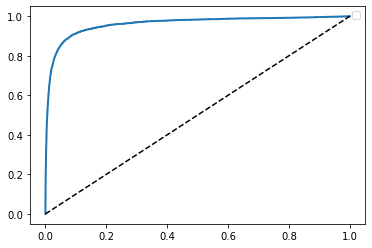

In [73]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagnoal
    plt.legend()
    
plot_roc_curve(fpr, tpr)
plt.show()

In [63]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [64]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [70]:
y_probas_forest[:,1] # proba of a positive class

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

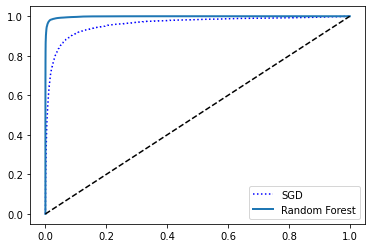

In [74]:
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [75]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [81]:
# one vs all
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [82]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [84]:
np.argmax(some_digit_scores)
print(sgd_clf.classes_) #something wrong with the sgd_clf

[0 1 2 3 4 5 6 7 8 9]


In [85]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [86]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [90]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

In [91]:
# StandardScaler did improve although the runtime was noticeably longer

In [92]:
# swapping sgd with forest_clf since my sgd did not perform as expected there
# begins analysis for errors
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)


In [93]:
conf_mx = confusion_matrix(y_train, y_train_pred)

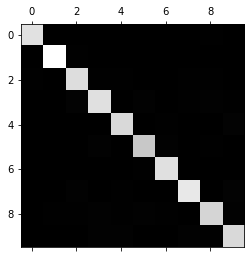

In [94]:
# rows = actual classes, columns = predicted classes
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

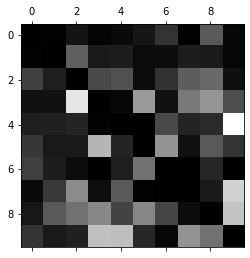

In [97]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [98]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


In [102]:
# need to run this function before (not in the book but found on github)
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.array(instances.iloc[i]).reshape(size, size) for i in range(instances.shape[0])] #change done here
    
    if images_per_row == 0:
       images_per_row = 0.1
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

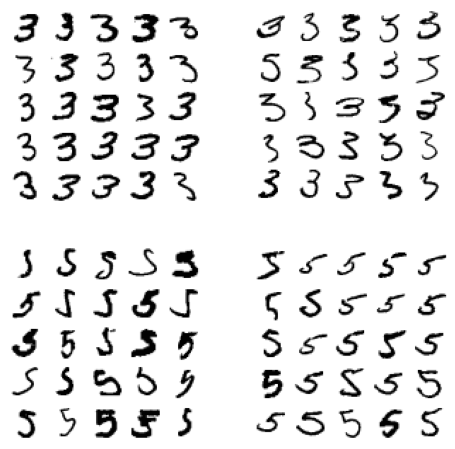

In [103]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [104]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [105]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [106]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [108]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

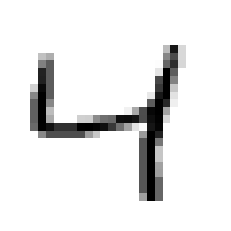

In [111]:
# not in the book but visualizing the clean vs noise
clean_digit = X.to_numpy()[2]
clean_digit_image = clean_digit.reshape(28,28)

plt.imshow(clean_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

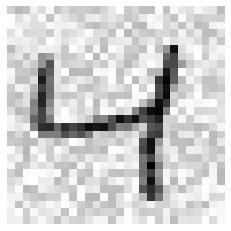

In [112]:
noise_digit = X_train_mod.to_numpy()[2]
noise_digit_image = noise_digit.reshape(28,28)

plt.imshow(noise_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

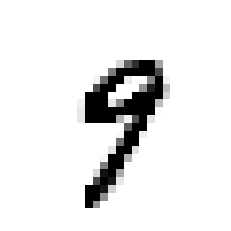

In [120]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit_t = knn_clf.predict([X_test_mod.to_numpy()[20]])
clean_digit_t_image = clean_digit_t.reshape(28,28)

plt.imshow(clean_digit_t_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

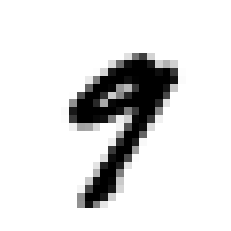

In [125]:
X_test_digit = X_test.to_numpy()[20]
X_test_digit_t_orig_image = X_test_digit.reshape(28,28)

plt.imshow(X_test_digit_t_orig_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()